In [3]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import yfinance as yf
import numpy as np

In [36]:
# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
# px를 쉽고 빠르게 붙여주는 모듈 cufflinksget_rsi
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
## plt.style.use("fivethirtyeight")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (10,6)

In [5]:
%run ../library/QUANT_FUNCTIONS.ipynb
Q = QUANT()
D = DATA()

###### 공통함수

In [6]:
## 수치형 데이터프레임을 시작점기준으로 지수화
def index_values(df):
    for i in df.columns:
        if (df[i].dtype == float)|(df[i].dtype == int):
            df[i] = df[i]/df[i][0]
        else:
            df[i] = df[i]
    return df

## 올웨더 전략

### 데이터 불러오기

In [7]:
## 데이터 불러오기
def get_AWP_df(first_ticker, second_ticker, fixed_ticker, gold_ticker, etc_ticker):
    ## 주투자자산, 보조투자자산, 안전자산
    first = yf.Ticker(first_ticker)
    second= yf.Ticker(second_ticker)
    fixed = yf.Ticker(fixed_ticker)
    gold = yf.Ticker(gold_ticker)
    etc = yf.Ticker(etc_ticker)

    first_df = first.history(period="max")
    second_df = second.history(period="max")
    fixed_df = fixed.history(period="max")
    gold_df = gold.history(period="max")
    etc_df = etc.history(period="max")
    
    df = pd.concat([first_df['Close'], second_df['Close'], fixed_df['Close'], gold_df['Close'], etc_df['Close']], axis = 1)
    df.columns = [first_ticker, second_ticker, fixed_ticker, gold_ticker, etc_ticker]
    df = df.dropna()
    
    return df

### AWP전략 구현

In [8]:
def cal_AWP(df, ratio = [0.5, 0.5], rebalancing=None, unit = None):
    new_df = df.copy()
    ## rebalancing 'm'월, 'y'연, 
    df_dict = []
    ## 데이터 분할
    years = sorted(new_df.index.year.unique())
    months = sorted(new_df.index.month.unique())
    
    ## 가치변화 계산용(월단위 집계데이터로 계산할 때 발생하는 에러보정)
    if (rebalancing == 'm')&(unit == 'monthly'):
        temp_df = new_df.copy()
        temp_df.index = temp_df.index - dt.timedelta(days=1)
        new_df = new_df.append(temp_df)
        new_df = new_df.sort_index()
        new_df = new_df.shift(-1).dropna()
        
    if rebalancing == 'm' :
        for year in years:
            for month in months:
                temp = new_df[(new_df.index.year == year)&(new_df.index.month == month)]
                if len(temp) > 0:
                    df_dict.append(temp)
                    
    elif rebalancing == 'y':
        for year in years:
            temp = new_df[(new_df.index.year == year)]
            if len(temp) > 0:
                df_dict.append(temp)
    else:
        df_dict.append(new_df)
    ## 리벨런싱 적용
    prev_val = 1
    temp_series = pd.Series()
    for i in range(len(df_dict)):    
        temp = index_values(df_dict[i])
        temp_AWP = (temp * ratio).sum(axis=1)*prev_val
        prev_val = temp_AWP[-1]
        temp_series = temp_series.append(temp_AWP)
    new_df['strategy'] = temp_series
    
    ## 가치변화 계산용 임시 데이터프레임을 원래 형태로 되돌림
    if (rebalancing == 'm')&(unit == 'monthly'):
        new_df['temp_y'] = new_df.index.year
        new_df['temp_m'] = new_df.index.month
        new_df = new_df.drop_duplicates(['temp_y', 'temp_m'])
        new_df = new_df.drop(columns=['temp_y', 'temp_m'])
        new_df.index = df.index
    
    return new_df

## 최적화

In [9]:
def cal_optimal(df, df_unit='monthly', rebalancing = 'm'):
    ## df_unit 데이터 집계주기 : daily, monthly => 수익, 위험 연율화 계산에 사용
    ## rebalancing 리벨런싱 주기 : None, m, y
    pyrr = []     # 리스트 형태로 수익을 쌓을 장소
    pydd = []     # 리스트 형태로 위험(표준편차)을 쌓을 장소
    pstn = []
    pstn = []
    _vol = []
    _sharp = []
    weghs = []
    for p in range (3000):
        if p%10 == 0:
            print(f"{p}단계 진행중")
        weights = np.random.random(len(df.T))   # 랜덤한 n개의 숫자를 생성함(n개의 자산에 대응)
        weights /= np.sum(weights)     # n개의 숫자의 합계가 1이 되도록 조정함(각 자산의 비중)

        result_df = cal_AWP(df, weights, rebalancing=rebalancing, unit=df_unit)
        sortino = Q.get_Vol_report(result_df, 'a', unit=df_unit)

        pyrr.append(sortino['Return'][len(sortino)-1])
        pydd.append(sortino['Volatility(Down)'][len(sortino)-1])
        pstn.append(sortino['Sortino Ratio'][len(sortino)-1])
        _vol.append(sortino['Volatility'][len(sortino)-1])
        _sharp.append(sortino['Sharpe Ratio'][len(sortino)-1])
        weghs.append(weights)

    pyrr = np.array(pyrr)
    pydd = np.array(pydd)
    pstn = np.array(pstn)
    _vol = np.array(_vol)
    _sharp = np.array(_sharp)
    weghs = np.array(weghs)

    process = pd.DataFrame(weghs, columns=df.columns)
    process['Return'] = pyrr
    process['Volatility(Down)'] = pydd
    process['Sortino Ratio'] = pstn
    process['Volatility'] = _vol
    process['Sharpe Ratio'] = _sharp
    
    obtimal = process[process['Sortino Ratio']==process['Sortino Ratio'].max()]
    obtimal = obtimal.reset_index(drop=True)
    min_risk = process[process['Return']==process['Return'].min()]
    min_risk = min_risk.reset_index(drop=True)

    return process, obtimal, min_risk

## 활용

In [10]:
## 올웨더 최적화 ## TQQQ;*3 TYD;7~10,*3 ## TMF;20+,*3 ## IAU;금,*1 ## DBC;원자재*1
AWP_df = D.get_merged_df('SPY', 'QQQ', 'VEA', 'VWO', 'TLT', 'IEF', 'SHY', 'IAU', 'DBC')
AWP_df = AWP_df.dropna()
## 백데이터 기간정의(10년 2600일)
## AWP_df = AWP_df.iloc[-2515:]

In [29]:
## trainset = AWP_df[AWP_df.index >= '2020-01-01']
trainset = AWP_df.copy()
process, obtimal, min_risk = cal_optimal(trainset, df_unit='daily', rebalancing = 'd')

0단계 진행중
10단계 진행중
20단계 진행중
30단계 진행중
40단계 진행중
50단계 진행중
60단계 진행중
70단계 진행중
80단계 진행중
90단계 진행중
100단계 진행중
110단계 진행중
120단계 진행중
130단계 진행중
140단계 진행중
150단계 진행중
160단계 진행중
170단계 진행중
180단계 진행중
190단계 진행중
200단계 진행중
210단계 진행중
220단계 진행중
230단계 진행중
240단계 진행중
250단계 진행중
260단계 진행중
270단계 진행중
280단계 진행중
290단계 진행중
300단계 진행중
310단계 진행중
320단계 진행중
330단계 진행중
340단계 진행중
350단계 진행중
360단계 진행중
370단계 진행중
380단계 진행중
390단계 진행중
400단계 진행중
410단계 진행중
420단계 진행중
430단계 진행중
440단계 진행중
450단계 진행중
460단계 진행중
470단계 진행중
480단계 진행중
490단계 진행중
500단계 진행중
510단계 진행중
520단계 진행중
530단계 진행중
540단계 진행중
550단계 진행중
560단계 진행중
570단계 진행중
580단계 진행중
590단계 진행중
600단계 진행중
610단계 진행중
620단계 진행중
630단계 진행중
640단계 진행중
650단계 진행중
660단계 진행중
670단계 진행중
680단계 진행중
690단계 진행중
700단계 진행중
710단계 진행중
720단계 진행중
730단계 진행중
740단계 진행중
750단계 진행중
760단계 진행중
770단계 진행중
780단계 진행중
790단계 진행중
800단계 진행중
810단계 진행중
820단계 진행중
830단계 진행중
840단계 진행중
850단계 진행중
860단계 진행중
870단계 진행중
880단계 진행중
890단계 진행중
900단계 진행중
910단계 진행중
920단계 진행중
930단계 진행중
940단계 진행중
950단계 진행중
960단계 진행중
970단계 진행중
980단계 진행중
990단계 진행중
1000단계 진행중


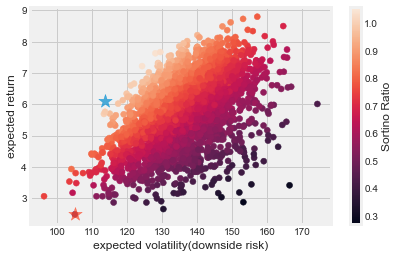

In [30]:
plt.scatter(process['Volatility'], process['Return'], c=process['Sortino Ratio'], marker='o')
plt.grid(True)
plt.xlabel('expected volatility(downside risk)')
plt.ylabel('expected return')
plt.colorbar(label='Sortino Ratio')

plt.scatter(obtimal['Volatility'][0], obtimal['Return'][0], marker="*", s=200, alpha=0.7)
plt.scatter(min_risk['Volatility'][0], min_risk['Return'][0], marker="*", s=200, alpha=0.7)

plt.show()

In [16]:
## ('UPRO', 'TQQQ', 'EURL', 'EDC', 'TMF', 'TYD', 'SHY', 'IAU', 'DBC')
## [0.24, 0.03, 0.01, 0.04, 0.20, 0.09, 0.09 , 0.24, 0.06]

In [17]:
test = process[process['YRR']>=0.08]

In [18]:
obtimal = test[test['Sortino Ratio'] == test['Sortino Ratio'].max()]

In [19]:
AWP_ratio = pd.DataFrame(list(obtimal.values[0][:-3]),
             index=['SPY', 'QQQ', 'VEA', 'VWO', 'TLT', 'IEF', 'SHY', 'IAU', 'DBC'], columns=['ratio'])
AWP_ratio = AWP_ratio.apply(lambda x:x.round(2))

In [ ]:
AWP_ratio

In [14]:
## 올웨더 전략 실행
## ratio = list(obtimal.values[0][:-3])
ratio = [0.07, 0.28, 0.01, 0.10, 0.22, 0.24, 0.01, 0.06, 0.01]
## ratio = [0.25, 0.2, 0.02, 0.02, 0.15, 0.15, 0.15, 0.05, 0.01]
AWP_result = cal_AWP(AWP_df, ratio=ratio, rebalancing='m')
## 듀올 전략 실행
## dual_df = get_dual_df('TQQQ', 'UPRO', 'TMF')
## dual_df_result = get_strategy_value(dual_df)

In [15]:
'''## 수정 AWP
TAWP_df = D.get_merged_df('UPRO', 'TQQQ', 'TMF', 'TYD')
TAWP_df = TAWP_df.dropna()
AWP_result = cal_AWP(TAWP_df, ratio=[0.25, 0.25, 0.25, 0.25], rebalancing='m')
## 듀올 전략 실행
## dual_df = get_dual_df('TQQQ', 'UPRO', 'TMF')
## dual_df_result = get_strategy_value(dual_df)'''

"## 수정 AWP\nTAWP_df = D.get_merged_df('UPRO', 'TQQQ', 'TMF', 'TYD')\nTAWP_df = TAWP_df.dropna()\nAWP_result = cal_AWP(TAWP_df, ratio=[0.25, 0.25, 0.25, 0.25], rebalancing='m')\n## 듀올 전략 실행\n## dual_df = get_dual_df('TQQQ', 'UPRO', 'TMF')\n## dual_df_result = get_strategy_value(dual_df)"

In [16]:
## 결과 통합
result_df = AWP_result.copy()
## result_df['Dual'] = dual_df_result['strategy']
## result_df['signal'] = dual_df_result['signal']

result_df = result_df.dropna()

## 표준화
result_df = index_values(result_df)

In [25]:
AWP_ratio.to_csv('result/AWP_ratio_2022.csv')

In [27]:
result_df.to_csv('result/AWP_result_2022.csv')

###### 보고서

In [18]:
## 월단위 리벨런싱
result_df['year'] = result_df.index.year
result_df['month'] = result_df.index.month

result_df = result_df.drop_duplicates(['year', 'month'], keep='last')
result_df = result_df.drop(columns=['year', 'month'])

In [53]:
def get_INDI(df, seed, duration = 120, sts = 0):
    '''
    df: 종가데이터
    sts: 초기투자금
    seed: 월납입액
    '''
    tickers = list(df.columns)
    df = df.dropna()
    df = day_to_mth(df)
    df = df.tail(duration)

    for ticker in tickers:
        df[f"{ticker}_quant"] = (float(seed)/df[ticker]).apply(lambda x:math.floor(x))
        df[f"{ticker}_cost"] = df[ticker] * df[f"{ticker}_quant"]

        df[f"{ticker}_cquant"] = df[f"{ticker}_quant"].cumsum()
        df[f"{ticker}_cquant"] = df[f"{ticker}_cquant"] + math.floor(sts/df[ticker][0])
        ## df[f"{ticker}_ccost"] = df[f"{ticker}_cost"].cumsum()
        df[ticker] = df[ticker] * df[f"{ticker}_cquant"]

    df = df[tickers]
    df['seed'] = seed
    df['seed'] = df['seed'].cumsum() + sts
    return df

In [54]:
import math

In [55]:
## 월단위 변환 함수
def day_to_mth(dataset):
    df = dataset.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    ## df = df[df['day']>=24]

    df = df.drop_duplicates(['year', 'month'], keep='last')
    df = df.drop(columns=['year', 'month', 'day'])
    return df

In [81]:
tt = result_df.copy()
tt = get_INDI(tt, 100, duration = 12*15)
tt = tt[['strategy', 'seed']]
tt.columns = ['올웨더전략', 'seed']

In [82]:
tt[['올웨더전략', 'seed']].astype(int)

,올웨더전략,seed
Date,,
2008-03-31,99,100
2008-04-30,200,200
2008-05-30,299,300
2008-06-30,390,400
2008-07-31,487,500
...,...,...
2022-10-31,25299,17600
2022-11-30,26997,17700
2022-12-30,25748,17800


In [86]:
8000/18000

0.4444444444444444

In [87]:
Q.get_YTD_report(result_df, 'a')

,SPY,QQQ,VEA,VWO,TLT,IEF,SHY,IAU,DBC,strategy
Date,,,,,,,,,,
2008,-36.79,-41.73,-40.62,-52.46,33.95,17.92,6.62,5.11,-31.80,-11.55
2009,26.35,54.68,27.51,76.31,-21.81,-6.59,0.35,23.90,16.19,14.77
2010,15.06,20.14,8.35,19.48,9.01,9.36,2.28,29.46,11.90,11.11
2011,1.89,3.48,-12.31,-18.75,34.00,15.65,1.44,9.57,-2.58,10.27
2012,15.99,18.11,18.56,19.21,2.41,3.66,0.25,6.89,3.50,8.52
2013,32.31,36.63,21.81,-4.94,-13.38,-6.09,0.21,-28.26,-7.63,3.16
2014,13.46,19.18,-5.97,-0.04,27.30,9.07,0.45,-2.05,-28.10,15.45
2015,1.23,9.44,-0.37,-15.82,-1.79,1.51,0.43,-10.58,-27.59,-0.05
2016,12.00,7.10,2.63,12.17,1.17,1.00,0.82,8.31,18.56,5.89


In [88]:
MDD, HRR = Q.get_MDD_report(result_df, 'a')
MDD

,MDD(%),Date
Ticker,,
SPY,-50.78,2009-02-27
QQQ,-49.74,2009-02-27
VEA,-57.05,2009-02-27
VWO,-61.69,2009-02-27
TLT,-41.63,2022-10-31
IEF,-21.19,2022-10-31
SHY,-5.36,2022-10-31
IAU,-42.59,2015-12-31
DBC,-74.55,2020-04-30


In [90]:
Q.get_Vol_report(result_df, 'a', unit='monthly')

,Return,Volatility,Sharpe Ratio,Volatility(Down),Sortino Ratio
Ticker,,,,,
SPY,8.88,74.70,0.12,10.93,0.81
QQQ,13.47,81.70,0.16,12.43,1.08
VEA,2.67,80.29,0.03,13.15,0.20
VWO,1.80,86.91,0.02,15.01,0.12
TLT,3.93,70.39,0.06,8.65,0.45
IEF,3.30,48.24,0.07,4.06,0.81
SHY,1.30,22.20,0.06,0.75,1.73
IAU,6.42,77.64,0.08,10.83,0.59
DBC,-0.12,82.87,-0.00,14.64,-0.01


In [35]:
result_df.to_csv('result/AWP_result.csv')

In [38]:
result_df[['strategy', 'SPY', 'QQQ']].iplot()